# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [20]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert, periodogram
from PyEMD import EMD, CEEMDAN

# regridding package
import xesmf as xe

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

## Load ENSO and IPO indices

### Regular IPO index

In [131]:
dates = pd.date_range(start="1958-01-01", end="2024-12-31", freq="M")


/jobfs/141768065.gadi-pbs/ipykernel_1131480/3220979946.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="1958-01-01", end="2024-12-31", freq="M")


/jobfs/141768065.gadi-pbs/ipykernel_1131480/4183052769.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="1958-01-01", end="2024-12-31", freq="M")


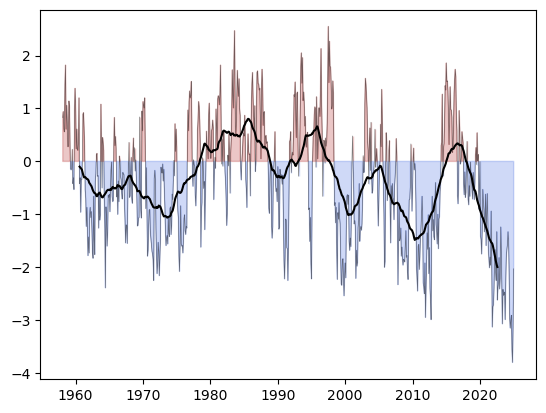

In [132]:
'''
https://www.ncei.noaa.gov/access/monitoring/pdo/
'''

dates = pd.date_range(start="1958-01-01", end="2024-12-31", freq="M")

ipo_index = pd.read_csv(wrkdir + "/data/IPO.txt", delimiter=',')
ipo_index[ipo_index == 99.99] = np.nan

ipo_subset = ipo_index[(ipo_index['Year']>1957) & (ipo_index['Year']<2025)]
ipo_subset.drop(columns='Year').values.flatten()
ipo = pd.DataFrame(
    {"time": dates,
     "index": ipo_subset.drop(columns='Year').values.flatten(),
    }
)

ipo['pos'] = ipo['index'][ipo['index']>0.0]
ipo['neg'] = ipo['index'][ipo['index']<0.0]
ipo['smooth'] = ipo['index'].rolling(window=60, center=True).mean()

plt.figure()
plt.plot(ipo['time'], ipo['index'], 'k-', alpha=0.5, linewidth=0.5)
plt.fill_between(ipo['time'], 0, ipo['pos'], color='firebrick', alpha=0.25)
plt.fill_between(ipo['time'], 0, ipo['neg'], color='royalblue', alpha=0.25)
plt.plot(ipo['time'], ipo['smooth'], 'k-', alpha=1.0)



### Tripolar IPO index

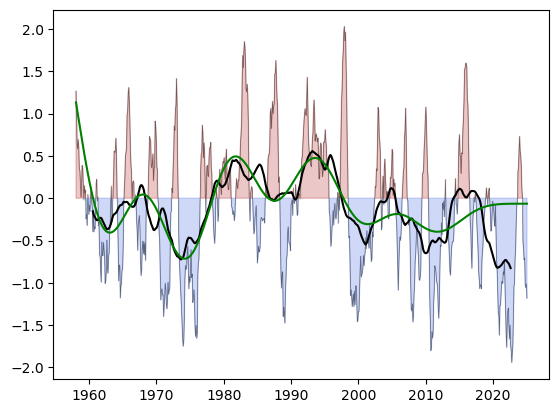

In [133]:

'''
https://psl.noaa.gov/data/timeseries/IPOTPI/
 (filitered from NOAA ERSST V5)
'''

tpi_index = pd.read_csv(wrkdir + "/data/Tripolar_IPO.txt", delimiter=',')
tpi_index[tpi_index == 99.99] = np.nan

tpi_subset = tpi_index[(tpi_index['Year']>1957) & (tpi_index['Year']<2025)]
tpi_subset.drop(columns='Year').values.flatten()
tpi = pd.DataFrame(
    {"time": dates,
     "index": tpi_subset.drop(columns='Year').values.flatten(),
    }
)

from scipy.signal import cheby1, filtfilt
# Following Henley et al (2015), filter the raw TPI with a Chebyshev filter with a normalized cutoff frequency = 1 / (13 years), assuming monthly data
nyq = 0.5 * 12  # Nyquist frequency (6 cycles/year for monthly)
cutoff = 1 / 13.0  # 1 cycle per 13 years
wn = cutoff / nyq
# Design a Chebyshev Type I low-pass filter
b, a = cheby1(N=6, rp=0.05, Wn=wn, btype='low', analog=False)
tpi['cheby'] = filtfilt(b, a, tpi['index']) # Henley et al (2015)


tpi['pos'] = tpi['index'][tpi['index']>0.0]
tpi['neg'] = tpi['index'][tpi['index']<0.0]
tpi['smooth'] = tpi['index'].rolling(window=60, center=True).mean()                   

plt.figure()
plt.plot(tpi['time'], tpi['index'], 'k-', alpha=0.5, linewidth=0.5)
plt.fill_between(tpi['time'], 0, tpi['pos'], color='firebrick', alpha=0.25)
plt.fill_between(tpi['time'], 0, tpi['neg'], color='royalblue', alpha=0.25)
plt.plot(tpi['time'], tpi['smooth'], 'k-', alpha=1.0)
plt.plot(tpi['time'], tpi['cheby'], 'g-', alpha=1.0)


### ENSO index

/jobfs/141768065.gadi-pbs/ipykernel_1131480/2507760179.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  enso_index = pd.read_csv(wrkdir + "/data/ONI.txt", delimiter=', ')


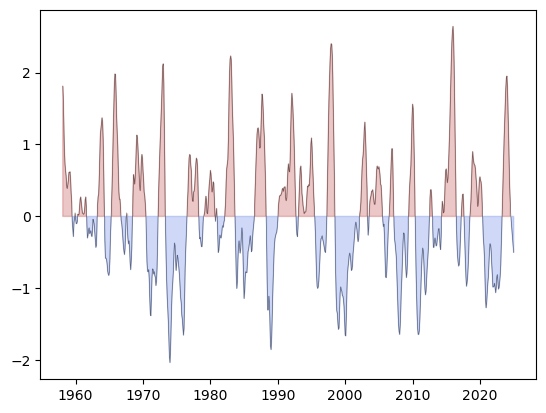

In [134]:
'''
https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php
'''

enso_index = pd.read_csv(wrkdir + "/data/ONI.txt", delimiter=', ')
enso_subset = enso_index[(enso_index['YR']>1957) & (enso_index['YR']<2025)]
enso = pd.DataFrame(
    {"time": dates,
     "index": enso_subset.drop(columns=['SEAS','YR']).squeeze(),
    }
)

enso['pos'] = enso['index'][enso['index']>0.0]
enso['neg'] = enso['index'][enso['index']<0.0]

plt.figure()
plt.plot(enso['time'], enso['index'], 'k-', alpha=0.5, linewidth=0.5)
plt.fill_between(enso['time'], 0, enso['pos'], color='firebrick', alpha=0.25)
plt.fill_between(enso['time'], 0, enso['neg'], color='royalblue', alpha=0.25)


## Determine the IPO using the TPI

#### Do so using our signal decomposition method:
    1. Use CEEMDAN from pyEMD to reduce TPI signal to IMFs
    2. Assess power spectra of resulting IMFs using periodogram
    3. Using predefined frequency cutoffs of 1/7 and 1/25 years, define a weighting to each IMF
    4. Apply weights based on the integrated variability within these bounds to the IMFs to extract the IPO

In [135]:
tpi

,time,index,cheby,pos,neg,smooth
0,1958-01-31,1.266,1.133937,1.266,NaN,NaN
1,1958-02-28,1.041,1.091610,1.041,NaN,NaN
2,1958-03-31,0.664,1.049312,0.664,NaN,NaN
3,1958-04-30,0.585,1.007078,0.585,NaN,NaN
4,1958-05-31,0.694,0.964942,0.694,NaN,NaN
...,...,...,...,...,...,...
799,2024-08-31,-0.707,-0.064409,NaN,-0.707,NaN
800,2024-09-30,-1.022,-0.064407,NaN,-1.022,NaN
801,2024-10-31,-1.058,-0.064406,NaN,-1.058,NaN
802,2024-11-30,-1.012,-0.064406,NaN,-1.012,NaN


CPU times: user 6.19 s, sys: 3.57 ms, total: 6.19 s
Wall time: 6.19 s


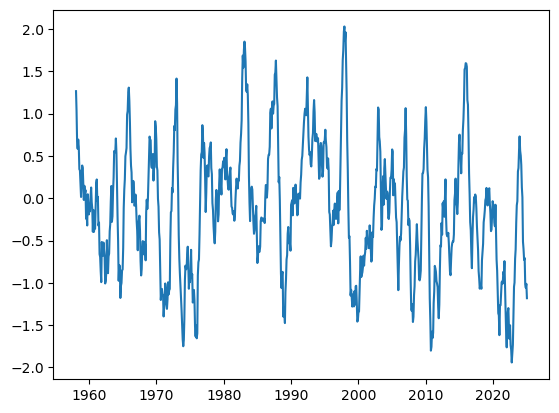

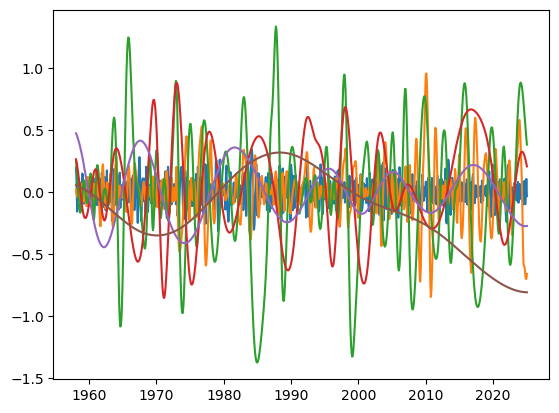

In [136]:
%%time

# Setup CEEMDAN config
def make_ceemdan():
    ceemdan = CEEMDAN()
    ceemdan.noise_seed = 42
    ceemdan.num_siftings = 100
    ceemdan.Nstd = 0.2
    ceemdan.trials = 100
    return ceemdan

ceemdan = make_ceemdan()  # Create fresh CEEMDAN instance (safe in parallel)
tpi_imfs = ceemdan(tpi['index'].values)
np.shape(tpi_imfs)

plt.figure()
plt.plot(tpi['time'], tpi['index'])
plt.figure()
plt.plot(tpi['time'], tpi_imfs[0,:])
plt.plot(tpi['time'], tpi_imfs[1,:])
plt.plot(tpi['time'], tpi_imfs[2,:])
plt.plot(tpi['time'], tpi_imfs[3,:])
plt.plot(tpi['time'], tpi_imfs[4,:])
plt.plot(tpi['time'], tpi_imfs[5,:])

(6, 403)
(6, 403)


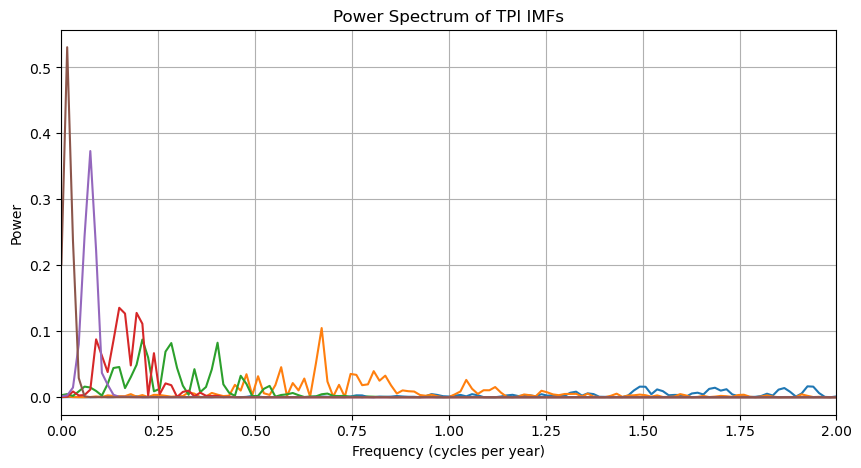

In [137]:
from scipy.signal import periodogram

fs = 12  # Hz (cycles per year)
freqs = []
power = []
for ii in np.arange(len(tpi_imfs[:,0])):
    f, p = periodogram(tpi_imfs[ii,:], fs=fs, scaling='density', window='hann')
    freqs.append(f)
    power.append(p)

freqs = np.array(freqs)
power = np.array(power)

print(np.shape(freqs))
print(np.shape(power))

plt.figure(figsize=(10, 5))
for ii in np.arange(len(tpi_imfs[:,0])):
    plt.plot(freqs[ii,:], power[ii,:]/np.sum(power[ii,:]))
plt.title("Power Spectrum of TPI IMFs")
plt.xlabel("Frequency (cycles per year)")
plt.ylabel("Power")
plt.grid(True)
plt.xlim(0, 2)  # Focus on 0–2 cycles/year (up to 6-year periodicity)
plt.show()

### Determine the weights to apply to the raw IMFS to generate high, mid, low and very low frequency bands

Band 1 cut off period of 0.0 and 1.0 years
Band 2 cut off period of 1.0 and 6.666666666666667 years
Band 3 cut off period of 6.666666666666667 and 100.0 years
Band 4 cut off period of 100.0 and -0.0 years
CPU times: user 24.7 ms, sys: 433 μs, total: 25.1 ms
Wall time: 23.8 ms


Text(0, 0.5, 'Weighting')

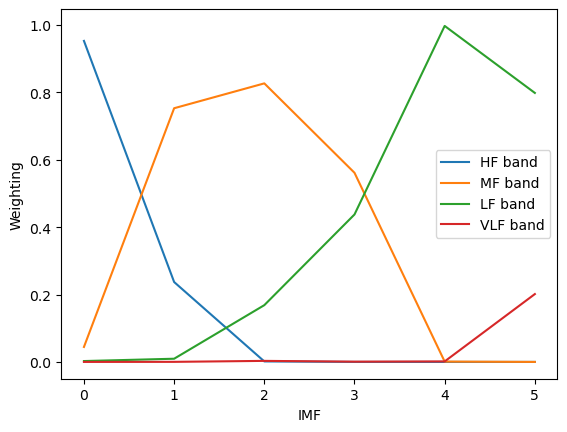

In [142]:
%%time

def compute_band_weights(freqs, power, bands):
    """
    freqs: shape (n_imfs, n_freqs)
    power: shape (n_imfs, n_freqs)
    bands: list of tuples [(f_min, f_max), ...]
    
    Returns:
        weights: shape (n_bands, n_imfs)
    """
    n_bands = len(bands)
    n_imfs = len(freqs[:,0])
    weights = np.zeros((n_bands, n_imfs))

    for i in range(n_imfs):
        total_power = np.sum(power[i,:])
        for j, (f_min, f_max) in enumerate(bands):
            mask = (freqs[i,:] >= f_min) & (freqs[i,:] < f_max)
            band_power = np.sum(power[i][mask])
            weights[j, i] = band_power / total_power if total_power > 0 else 0.0

    return weights

# Predefined cut-offs for frequency bands
bands = [
    (1.0, np.inf),       # Subannual
    (0.15, 1.0),         # Interannual
    (0.01, 0.15),        # Decadal
    (-np.inf, 0.01)       # Centennial or more
]

print(f"Band 1 cut off period of {1.0/bands[0][1]} and {1.0/bands[0][0]} years")
print(f"Band 2 cut off period of {1.0/bands[1][1]} and {1.0/bands[1][0]} years")
print(f"Band 3 cut off period of {1.0/bands[2][1]} and {1.0/bands[2][0]} years")
print(f"Band 4 cut off period of {1.0/bands[3][1]} and {1.0/bands[3][0]} years")

weights = compute_band_weights(freqs, power, bands)  # shape (4, n_imfs)
np.shape(weights)

plt.figure()
plt.plot(weights[0,:], label="HF band")
plt.plot(weights[1,:], label="MF band")
plt.plot(weights[2,:], label="LF band")
plt.plot(weights[3,:], label="VLF band")
plt.legend()
plt.xlabel("IMF")
plt.ylabel("Weighting")


In [143]:
tpi_pp_imfs = np.zeros((4,len(tpi_imfs[0,:])))

for b in np.arange(len(bands)):
    for imf in np.arange(len(tpi_imfs[:,0])):
        tpi_pp_imfs[b,:] = tpi_pp_imfs[b,:] + tpi_imfs[imf,:] * weights[b,imf]



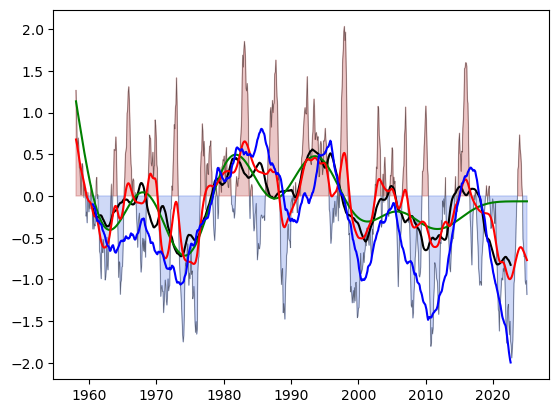

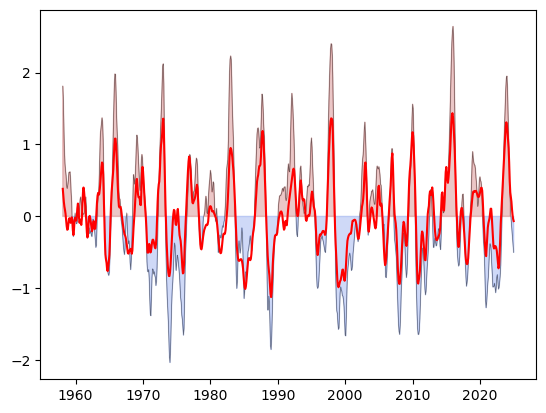

In [144]:
plt.figure()
plt.plot(tpi['time'], tpi['index'], 'k-', alpha=0.5, linewidth=0.5)
plt.fill_between(tpi['time'], 0, tpi['pos'], color='firebrick', alpha=0.25)
plt.fill_between(tpi['time'], 0, tpi['neg'], color='royalblue', alpha=0.25)
plt.plot(tpi['time'], tpi['smooth'], 'k-', alpha=1.0)
plt.plot(tpi['time'], tpi['cheby'], 'g-', alpha=1.0)
plt.plot(tpi['time'], tpi_pp_imfs[2,:], 'r-', alpha=1.0, linewidth=1.5)
plt.plot(ipo['time'], ipo['smooth'], 'b-', alpha=1.0)


plt.figure()
plt.plot(enso['time'], enso['index'], 'k-', alpha=0.5, linewidth=0.5)
plt.fill_between(enso['time'], 0, enso['pos'], color='firebrick', alpha=0.25)
plt.fill_between(enso['time'], 0, enso['neg'], color='royalblue', alpha=0.25)
plt.plot(tpi['time'], tpi_pp_imfs[1,:], 'r-', alpha=1.0, linewidth=1.5)



In [145]:
%%time

def find_imf_freq_Hilbert(imfs, years):
    inst_freqs = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years))
        inst_freqs.append(instantaneous_frequency)
    return np.array([np.mean(freq) for freq in inst_freqs])

tpi_imf_freqs = find_imf_freq_Hilbert(tpi_imfs, years)
tpi_pp_imf_freqs = find_imf_freq_Hilbert(tpi_pp_imfs, years)

analytic_signal = hilbert(tpi['index'].values)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
tpi_freq = np.mean(np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years)))

analytic_signal = hilbert(tpi['smooth'].values[31:-30])
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
tpi_smooth_freq = np.mean(np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years[31:-30])))

print(tpi_imf_freqs)
print(tpi_pp_imf_freqs)
print(tpi_freq)
print(tpi_smooth_freq)

[2.74548558 1.23830574 0.46279444 0.17950734 0.08771793 0.01368149]
[1.92419355 0.36414308 0.08792661 0.01367201]
0.3115248758794143
0.06330043409586085
CPU times: user 6.57 ms, sys: 1.23 ms, total: 7.8 ms
Wall time: 6.79 ms


## Make figure showcasing our method

Text(1.175, -0.1, 'sum of Bands\n=\noriginal signal')

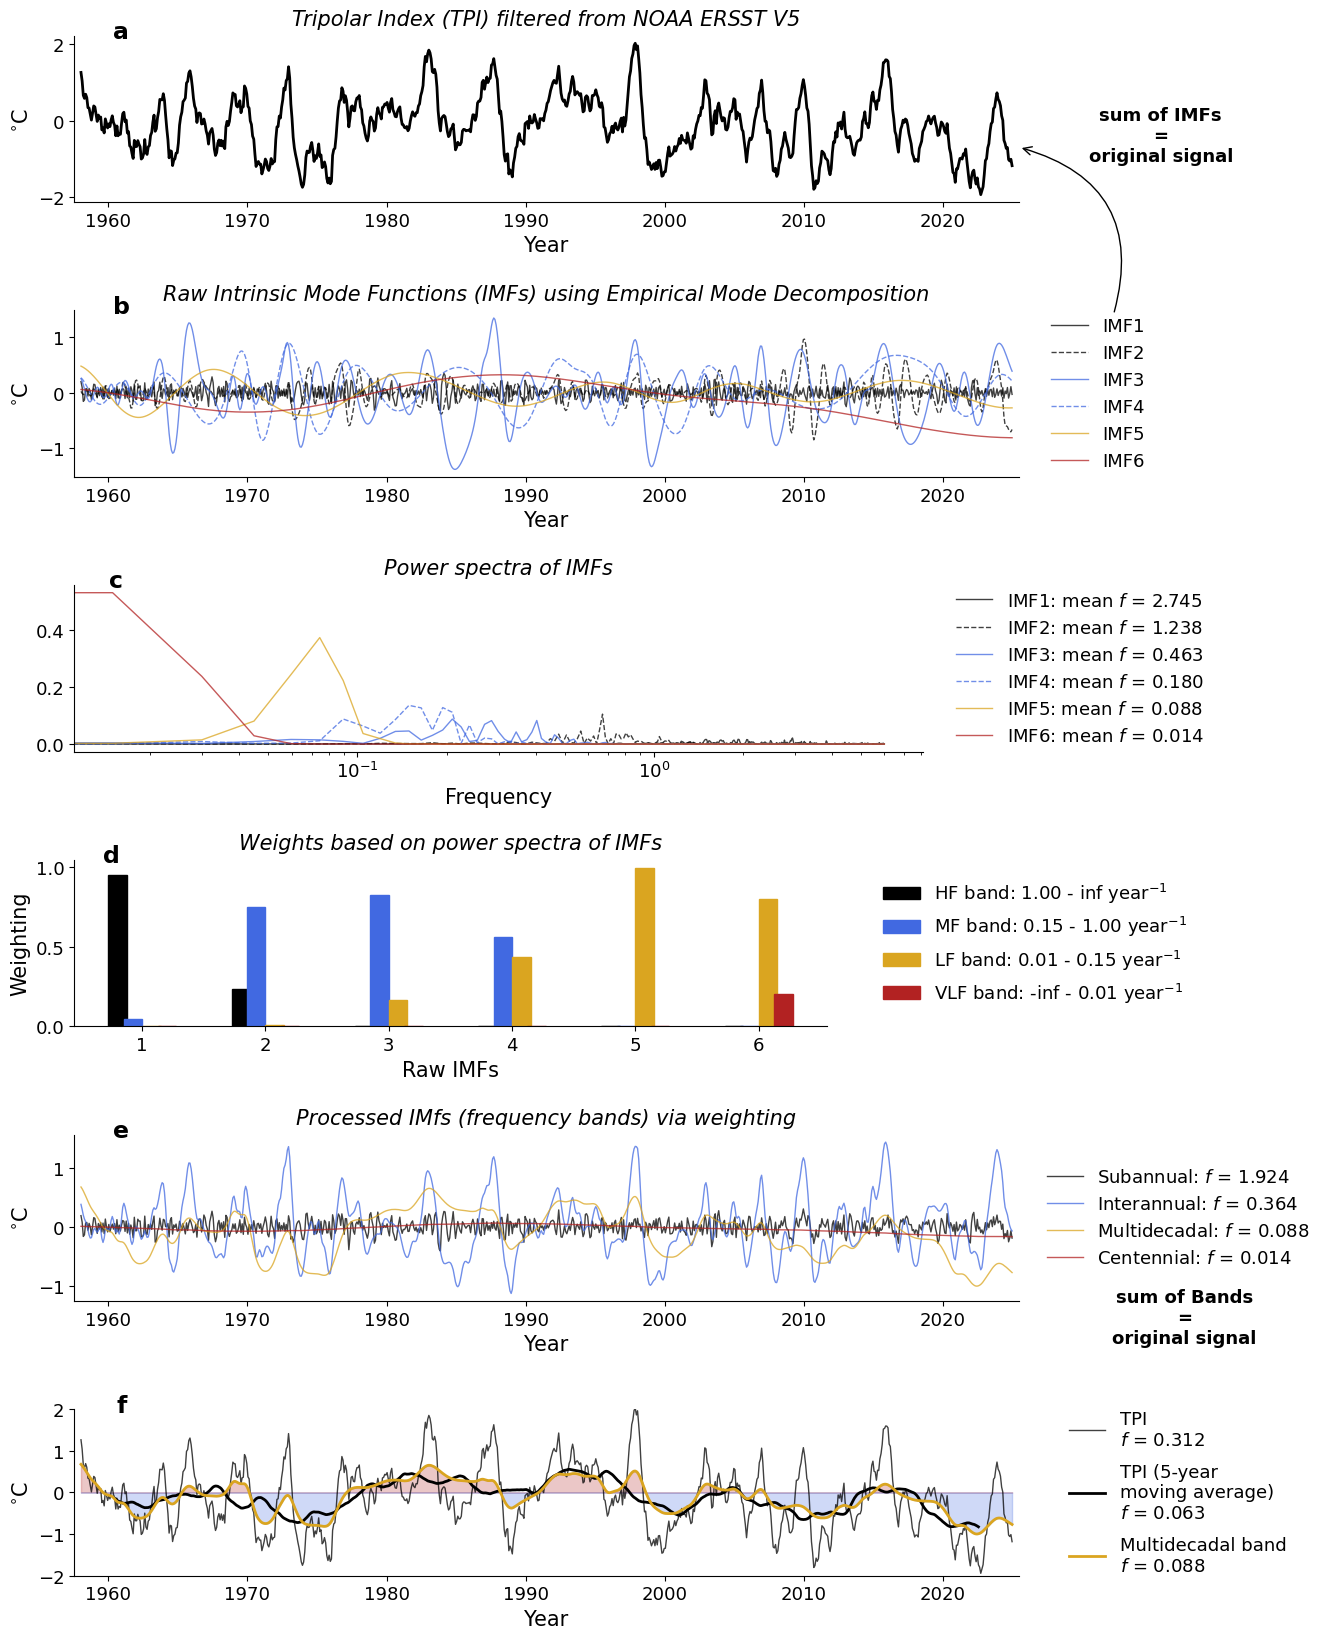

In [146]:
fslab = 15
fstic = 13
cols = ['k', 'k', 'royalblue', 'royalblue', 'goldenrod', 'firebrick']
lsty = ['-', '--', '-', '--', '-', '-']
lwid = [1.0, 1.0, 1.0, 1.0, 1.0, 1.00]
alf = [0.75, 0.75, 0.75, 0.75, 0.75, 0.75]

fig = plt.figure(figsize=(14,20))
gs = GridSpec(6,10)
ax1 = plt.subplot(gs[0,:])
ax2 = plt.subplot(gs[1,:])
ax3 = plt.subplot(gs[2,0:9])
ax4 = plt.subplot(gs[3,0:8])
ax5 = plt.subplot(gs[4,:])
ax6 = plt.subplot(gs[5,:])

ax1.tick_params(labelsize=fstic)
ax2.tick_params(labelsize=fstic)
ax3.tick_params(labelsize=fstic)
ax4.tick_params(labelsize=fstic)
ax5.tick_params(labelsize=fstic)
ax6.tick_params(labelsize=fstic)

ax1.spines[['top','right']].set_visible(False)
ax2.spines[['top','right']].set_visible(False)
ax3.spines[['top','right']].set_visible(False)
ax4.spines[['top','right']].set_visible(False)
ax5.spines[['top','right']].set_visible(False)
ax6.spines[['top','right']].set_visible(False)

ax1.plot(years, tpi['index'].values, color=cols[0], alpha=1.0, linestyle='-', linewidth=lwid[0]*2)
ax2.plot(years, tpi_imfs[0,:], label="IMF1", color=cols[0], alpha=alf[0], linestyle=lsty[0], linewidth=lwid[0])
ax2.plot(years, tpi_imfs[1,:], label="IMF2", color=cols[1], alpha=alf[1], linestyle=lsty[1], linewidth=lwid[1])
ax2.plot(years, tpi_imfs[2,:], label="IMF3", color=cols[2], alpha=alf[2], linestyle=lsty[2], linewidth=lwid[2])
ax2.plot(years, tpi_imfs[3,:], label="IMF4", color=cols[3], alpha=alf[3], linestyle=lsty[3], linewidth=lwid[3])
ax2.plot(years, tpi_imfs[4,:], label="IMF5", color=cols[4], alpha=alf[4], linestyle=lsty[4], linewidth=lwid[4])
ax2.plot(years, tpi_imfs[5,:], label="IMF6", color=cols[5], alpha=alf[5], linestyle=lsty[5], linewidth=lwid[5])

ax3.plot(freqs[0,:], power[0,:]/np.sum(power[0,:]), label="IMF1: mean $f$ = %.3f"%(tpi_imf_freqs[0]), color=cols[0], alpha=alf[0], linestyle=lsty[0], linewidth=lwid[0])
ax3.plot(freqs[1,:], power[1,:]/np.sum(power[1,:]), label="IMF2: mean $f$ = %.3f"%(tpi_imf_freqs[1]), color=cols[1], alpha=alf[1], linestyle=lsty[1], linewidth=lwid[1])
ax3.plot(freqs[2,:], power[2,:]/np.sum(power[2,:]), label="IMF3: mean $f$ = %.3f"%(tpi_imf_freqs[2]), color=cols[2], alpha=alf[2], linestyle=lsty[2], linewidth=lwid[2])
ax3.plot(freqs[3,:], power[3,:]/np.sum(power[3,:]), label="IMF4: mean $f$ = %.3f"%(tpi_imf_freqs[3]), color=cols[3], alpha=alf[3], linestyle=lsty[3], linewidth=lwid[3])
ax3.plot(freqs[4,:], power[4,:]/np.sum(power[4,:]), label="IMF5: mean $f$ = %.3f"%(tpi_imf_freqs[4]), color=cols[4], alpha=alf[4], linestyle=lsty[4], linewidth=lwid[4])
ax3.plot(freqs[5,:], power[5,:]/np.sum(power[5,:]), label="IMF6: mean $f$ = %.3f"%(tpi_imf_freqs[5]), color=cols[5], alpha=alf[5], linestyle=lsty[5], linewidth=lwid[5])

ax3.set_xscale('log')
#ax3.set_yscale('log')


ax4.bar(np.arange(len(tpi_imfs[:,0]))+0.8, weights[0,:], edgecolor=cols[0], facecolor=cols[0], width=0.15, label='HF band: %.2f - %.2f year$^{-1}$'%(bands[0][0], bands[0][1]))
ax4.bar(np.arange(len(tpi_imfs[:,0]))+0.925, weights[1,:], edgecolor=cols[2], facecolor=cols[2], width=0.15, label='MF band: %.2f - %.2f year$^{-1}$'%(bands[1][0], bands[1][1]))
ax4.bar(np.arange(len(tpi_imfs[:,0]))+1.075, weights[2,:], edgecolor=cols[4], facecolor=cols[4], width=0.15, label='LF band: %.2f - %.2f year$^{-1}$'%(bands[2][0], bands[2][1]))
ax4.bar(np.arange(len(tpi_imfs[:,0]))+1.2, weights[3,:], edgecolor=cols[5], facecolor=cols[5], width=0.15, label='VLF band: %.2f - %.2f year$^{-1}$'%(bands[3][0], bands[3][1]))

ax5.plot(years, tpi_pp_imfs[0,:], label="Subannual: $f$ = %.3f"%(tpi_pp_imf_freqs[0]), color=cols[0], alpha=alf[0], linestyle=lsty[0], linewidth=lwid[0])
ax5.plot(years, tpi_pp_imfs[1,:], label="Interannual: $f$ = %.3f"%(tpi_pp_imf_freqs[1]), color=cols[2], alpha=alf[1], linestyle=lsty[2], linewidth=lwid[1])
ax5.plot(years, tpi_pp_imfs[2,:], label="Multidecadal: $f$ = %.3f"%(tpi_pp_imf_freqs[2]), color=cols[4], alpha=alf[2], linestyle=lsty[4], linewidth=lwid[2])
ax5.plot(years, tpi_pp_imfs[3,:], label="Centennial: $f$ = %.3f"%(tpi_pp_imf_freqs[3]), color=cols[5], alpha=alf[3], linestyle=lsty[5], linewidth=lwid[3])
#ax6.plot(years, tpi['index'].values, label="TPI (raw)", color=cols[0], alpha=1.0, linestyle='-', linewidth=lwid[0]*2)
#ax6.plot(years, np.sum(tpi_pp_imfs[:,:], axis=0), label="Sum of bands", color=cols[0], alpha=1.0, linestyle='-', linewidth=lwid[0]*2)
ax6.plot(years, tpi['index'], label="TPI\n$f$ = %.3f"%(tpi_freq), color=cols[0], alpha=.75, linestyle='-', linewidth=lwid[0] )
ax6.plot(years, tpi['smooth'], label="TPI (5-year\nmoving average)\n$f$ = %.3f"%(tpi_smooth_freq), color=cols[0], alpha=1.0, linestyle='-', linewidth=lwid[0]*2 )
ax6.plot(years, tpi_pp_imfs[2,:], label="Multidecadal band\n$f$ = %.3f"%(tpi_pp_imf_freqs[2]), color=cols[4], alpha=1.0, linestyle='-', linewidth=lwid[0]*2)
#ax6.plot(years, ipo['smooth'] - tpi_imfs[-1,:], label="PDO (4-year\nmoving average)\nminus IMF6", color=cols[5], alpha=1.0, linestyle='-', linewidth=lwid[0]*2 )
ipo_pos = tpi_pp_imfs[2,:]*1
ipo_neg = tpi_pp_imfs[2,:]*1
ipo_pos[tpi_pp_imfs[2,:]<0.0] = 0.0
ipo_neg[tpi_pp_imfs[2,:]>0.0] = 0.0
ax6.fill_between(years, 0, ipo_pos, color='firebrick', alpha=0.25)
ax6.fill_between(years, 0, ipo_neg, color='royalblue', alpha=0.25)


ax2.legend(frameon=False, ncols=1, fontsize=fstic, bbox_to_anchor=(1.15,0.5), loc='center right')
ax3.legend(frameon=False, ncols=1, fontsize=fstic, bbox_to_anchor=(1.35,0.5), loc='center right')
ax4.legend(frameon=False, ncols=1, fontsize=fstic, bbox_to_anchor=(1.5,0.5), loc='center right')
ax5.legend(frameon=False, ncols=1, fontsize=fstic, bbox_to_anchor=(1.325,0.5), loc='center right')
ax6.legend(frameon=False, ncols=1, fontsize=fstic, bbox_to_anchor=(1.3,0.5), loc='center right', labelspacing=0.75)

ax1.set_xlabel("Year", fontsize=fslab)
ax2.set_xlabel("Year", fontsize=fslab)
ax3.set_xlabel("Frequency", fontsize=fslab)
ax4.set_xlabel("Raw IMFs", fontsize=fslab)
ax5.set_xlabel("Year", fontsize=fslab)
ax6.set_xlabel("Year", fontsize=fslab)

xx = 0.5; yy = 1.1
plt.text(xx,yy, "Tripolar Index (TPI) filtered from NOAA ERSST V5", va='center', ha='center', fontstyle='italic', fontsize=fslab, transform=ax1.transAxes)
plt.text(xx,yy, "Raw Intrinsic Mode Functions (IMFs) using Empirical Mode Decomposition", va='center', ha='center', fontstyle='italic', fontsize=fslab, transform=ax2.transAxes)
plt.text(xx,yy, "Power spectra of IMFs", va='center', ha='center', fontsize=fslab, fontstyle='italic', transform=ax3.transAxes)
plt.text(xx,yy, "Weights based on power spectra of IMFs", va='center', ha='center', fontstyle='italic', fontsize=fslab, transform=ax4.transAxes)
plt.text(xx,yy, "Processed IMfs (frequency bands) via weighting", va='center', ha='center', fontstyle='italic', fontsize=fslab, transform=ax5.transAxes)
#plt.text(xx,yy, "Checking energy conservation", va='center', ha='center', fontsize=fslab, transform=ax6.transAxes)

ax1.set_ylabel("$^{\circ}$C", fontsize=fslab)
ax2.set_ylabel("$^{\circ}$C", fontsize=fslab)
ax4.set_ylabel("Weighting", fontsize=fslab)
ax5.set_ylabel("$^{\circ}$C", fontsize=fslab)
ax6.set_ylabel("$^{\circ}$C", fontsize=fslab)

plt.subplots_adjust(hspace=0.65, right=0.8)

ax1.set_xlim(years[0]-0.5, years[-1]+0.5)
ax2.set_xlim(years[0]-0.5, years[-1]+0.5)

ax5.set_xlim(years[0]-0.5, years[-1]+0.5)
ax6.set_xlim(years[0]-0.5, years[-1]+0.5)
ax6.set_ylim(-2,2)

xx = 0.05; yy = 1.025
plt.text(xx,yy, "a", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax1.transAxes)
plt.text(xx,yy, "b", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax2.transAxes)
plt.text(xx,yy, "c", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax3.transAxes)
plt.text(xx,yy, "d", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax4.transAxes)
plt.text(xx,yy, "e", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax5.transAxes)
plt.text(xx,yy, "f", va='center', ha='center', fontsize=fslab+2, fontweight="bold", transform=ax6.transAxes)


### ADD FANCY ARROWS
from matplotlib.patches import FancyArrowPatch
from matplotlib.transforms import blended_transform_factory

# Get figure coordinates (0 to 1)
start = ax2.transAxes.transform((1.1, 0.975))  # right center of ax2
end = ax1.transAxes.transform((1.0, 0.33))    # left center of ax2
inv = fig.transFigure.inverted()
start_fig = inv.transform(start)
end_fig = inv.transform(end)

# Create and add curved arrow
arrow = FancyArrowPatch(
    posA=start_fig, posB=end_fig,
    path_effects=None,
    arrowstyle='->',
    connectionstyle='arc3,rad=0.5',  # curve amount
    mutation_scale=15,
    color='k',
    transform=fig.transFigure  # VERY IMPORTANT!
)
fig.patches.append(arrow)



plt.text(1.15,0.4, "sum of IMFs\n=\noriginal signal", fontsize=fstic, va='center', ha='center', fontweight='bold', transform=ax1.transAxes)
plt.text(1.175,-.1, "sum of Bands\n=\noriginal signal", fontsize=fstic, va='center', ha='center', fontweight='bold', transform=ax5.transAxes)

In [147]:
os.chdir(wrkdir)
fig.savefig("./figures/obs_derive_IPO.png", dpi=300)
fig.savefig("./figures/obs_derive_IPO_transparent.png", dpi=300, transparent=True)


## Save the derived IPO

In [20]:
os.chdir(wrkdir + "/data")

# Create xarray Datasets
my_IPO_ds = xr.Dataset(
    {
        "IPO": (["time"], tpi_pp_imfs[2,:]),
    },
    coords={
        "time": tpi['time'],
    },
)
os.chdir(wrkdir + "/data/")
#os.remove("derived_IPO.nc")
my_IPO_ds.to_netcdf("derived_IPO.nc")


## Load the ACCESS-ESM-1.5 TPI and derive the IPO via above method

In [42]:
%%time

wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)

dat = xr.open_dataset("./data/ACCESS-ESM1-5_TPI_unsmoothed.nc")
dat['r1i1p1f1'][0:10].values

CPU times: user 40.5 ms, sys: 1.75 ms, total: 42.3 ms
Wall time: 39.9 ms


array([ 1.0935256 ,  0.94422233,  1.0732589 ,  1.1720514 ,  1.0514264 ,
        0.9780191 ,  0.5489269 ,  0.2875077 , -0.0368536 , -0.15053727],
      dtype=float32)

### Method

In [43]:
%%time

# Setup CEEMDAN config
def make_ceemdan():
    ceemdan = CEEMDAN()
    ceemdan.noise_seed = 42
    ceemdan.num_siftings = 100
    ceemdan.Nstd = 0.2
    ceemdan.trials = 100
    return ceemdan

def find_freqs_power(data):
    fs = 12  # Hz (cycles per year)
    freqs = []
    power = []
    for ii in np.arange(len(data[:,0])):
        f, p = periodogram(data[ii,:], fs=fs, scaling='density', window='hann')
        freqs.append(f)
        power.append(p)
    return np.array(freqs), np.array(power)

def compute_band_weights(freqs, power, bands):
    n_bands = len(bands)
    n_imfs = len(freqs[:,0])
    weights = np.zeros((n_bands, n_imfs))
    for i in range(n_imfs):
        total_power = np.sum(power[i,:])
        for j, (f_min, f_max) in enumerate(bands):
            mask = (freqs[i,:] >= f_min) & (freqs[i,:] < f_max)
            band_power = np.sum(power[i][mask])
            weights[j, i] = band_power / total_power if total_power > 0 else 0.0
    return weights
    



CPU times: user 8 μs, sys: 0 ns, total: 8 μs
Wall time: 10.5 μs


In [45]:
%%time

# Predefined cut-offs for frequency bands
bands = [
    (1.0, np.inf),       # Subannual
    (0.15, 1.0),         # Interannual
    (0.01, 0.15),        # Decadal
    (-np.inf, 0.01)       # Centennial or more
]

print(f"Band 1 cut off period of {1.0/bands[0][1]} and {1.0/bands[0][0]} years")
print(f"Band 2 cut off period of {1.0/bands[1][1]} and {1.0/bands[1][0]} years")
print(f"Band 3 cut off period of {1.0/bands[2][1]} and {1.0/bands[2][0]} years")
print(f"Band 4 cut off period of {1.0/bands[3][1]} and {1.0/bands[3][0]} years")

var = 'r1i1p1f1'
ceemdan = make_ceemdan()  # Create fresh CEEMDAN instance (safe in parallel)
imfs = ceemdan(dat[var].dropna(dim='time').values)
freqs, power = find_freqs_power(imfs)
weights = compute_band_weights(freqs, power, bands)  # shape (4, n_imfs)
pp_imfs = np.zeros((4,len(imfs[0,:])))
for b in np.arange(len(bands)):
    for i in np.arange(len(imfs[:,0])):
        pp_imfs[b,:] = pp_imfs[b,:] + imfs[i,:] * weights[b,i]



Band 1 cut off period of 0.0 and 1.0 years
Band 2 cut off period of 1.0 and 6.666666666666667 years
Band 3 cut off period of 6.666666666666667 and 100.0 years
Band 4 cut off period of 100.0 and -0.0 years
CPU times: user 14.4 s, sys: 12.1 ms, total: 14.4 s
Wall time: 14.4 s


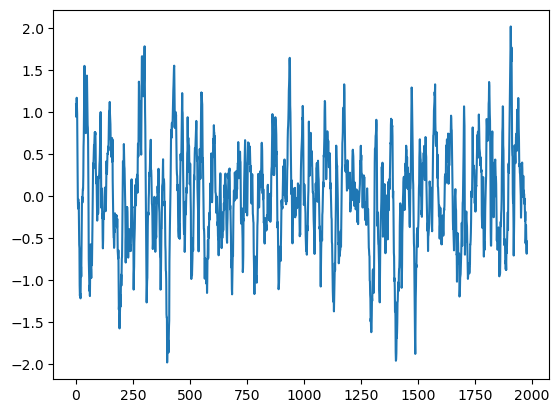

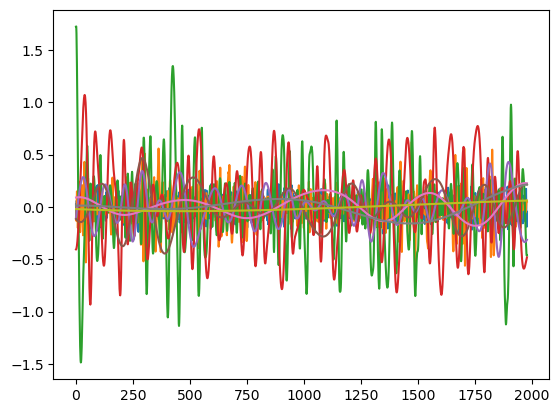

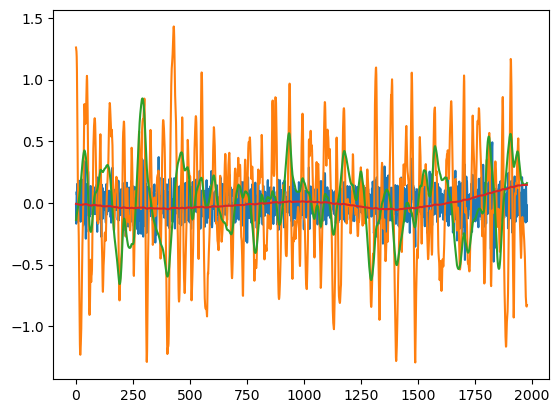

In [47]:

plt.figure()
plt.plot(dat[var].values)
plt.figure()
for i in range(len(imfs[:,0])):
    plt.plot(imfs[i,:])
plt.figure()
for i in range(len(pp_imfs[:,0])):
    plt.plot(pp_imfs[i,:])


In [49]:
%%time

# Predefined cut-offs for frequency bands
bands = [
    (1.0, np.inf),       # Subannual
    (0.15, 1.0),         # Interannual
    (0.01, 0.15),        # Decadal
    (-np.inf, 0.01)       # Centennial or more
]

print(f"Band 1 cut off period of {1.0/bands[0][1]} and {1.0/bands[0][0]} years")
print(f"Band 2 cut off period of {1.0/bands[1][1]} and {1.0/bands[1][0]} years")
print(f"Band 3 cut off period of {1.0/bands[2][1]} and {1.0/bands[2][0]} years")
print(f"Band 4 cut off period of {1.0/bands[3][1]} and {1.0/bands[3][0]} years")

ceemdan = make_ceemdan()  # Create fresh CEEMDAN instance (safe in parallel)

pp_bands = np.zeros((40,4,len(dat[var].dropna(dim='time').values)))
for mem,var in enumerate(dat.data_vars.keys()):
    print(f"Processing variable: {var}")
    imfs = ceemdan(dat[var].dropna(dim='time').values)
    freqs, power = find_freqs_power(imfs)
    weights = compute_band_weights(freqs, power, bands)  # shape (4, n_imfs)
    for b in np.arange(len(bands)):
        for i in np.arange(len(imfs[:,0])):
            pp_bands[mem,b,:] = pp_bands[mem,b,:] + imfs[i,:] * weights[b,i]



Band 1 cut off period of 0.0 and 1.0 years
Band 2 cut off period of 1.0 and 6.666666666666667 years
Band 3 cut off period of 6.666666666666667 and 100.0 years
Band 4 cut off period of 100.0 and -0.0 years
Processing variable: r1i1p1f1
Processing variable: r2i1p1f1
Processing variable: r3i1p1f1
Processing variable: r4i1p1f1
Processing variable: r5i1p1f1
Processing variable: r6i1p1f1
Processing variable: r7i1p1f1
Processing variable: r8i1p1f1
Processing variable: r9i1p1f1
Processing variable: r10i1p1f1
Processing variable: r11i1p1f1
Processing variable: r12i1p1f1
Processing variable: r13i1p1f1
Processing variable: r14i1p1f1
Processing variable: r15i1p1f1
Processing variable: r16i1p1f1
Processing variable: r17i1p1f1
Processing variable: r18i1p1f1
Processing variable: r19i1p1f1
Processing variable: r20i1p1f1
Processing variable: r21i1p1f1
Processing variable: r22i1p1f1
Processing variable: r23i1p1f1
Processing variable: r24i1p1f1
Processing variable: r25i1p1f1
Processing variable: r26i1p1f

### Save

In [51]:
%%time

# Create xarray Datasets
ds = xr.Dataset(
    {
        "IPO": (["member", "band", "time"], pp_bands),
    },
    coords={
        "member": np.arange(1,41,1),
        "band": np.arange(1,5,1),
        "time": dat.coords['time'],
    },
)

ds.to_netcdf("/g/data/es60/pjb581/SPC/data/ACCESS-ESM1-5_derived_IPO.nc")

